In [1]:
#from fenics import *
from Utilities import *
from scipy.stats import norm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import time
import scipy.sparse as ssp

from mpl_toolkits.mplot3d import axes3d

import multiprocessing
import copy
import pickle

In [22]:

# The Monte Carlo Simulation
def generateTrigonometricTrajectoriesMonteCarlo(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''
    # The decomposition of the stiffness matrix
    Q, sigma, QT = variables['alphaOperDecomp']
    
    # Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    # Space variables.
    spaceDiscr = parameter[1]
    
    # The covariance Operator
    eigV, eigF = variables['convOp']
    
    # The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    
    
    # Some concrete functions we might need:
    abstrLamb = lambda Q, s, QT, func, vec : np.dot( np.dot(Q, np.dot(np.diag(func(s)), QT)) , vec)
    # Some operator on the spectrum we will use.
    sink = lambda t : lambda x : np.sin( t*x**(1./2) )
    cosk = lambda t : lambda x : np.cos( t*x**(1./2) )
    Lambda = lambda s:  lambda x : x**(s)

    ### Frequent operators

    # C_h(k)
    cosOp = np.dot(Q, np.dot(np.diag(cosk(k)(sigma)), QT))
    # S_h(k)
    sinOp = np.dot(Q, np.dot(np.diag(sink(k)(sigma)), QT))
    # \Lambda^{-1/2}
    LambdaNegPow = np.dot(Q, np.dot(np.diag(Lambda(-1. / 2)(sigma)), QT))
    # \Lambda^{1/2}
    LambdaPosPow = np.dot(Q, np.dot(np.diag(Lambda(1. / 2)(sigma)), QT))

    
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        u = np.dot(cosOp, uPast) + np.dot(LambdaNegPow, np.dot(sinOp, vPast)) \
               + np.dot(LambdaNegPow, np.dot(sinOp, uPast)) * (randomField[n, :] - randomField[n - 1, :])

        v = - np.dot(LambdaPosPow, np.dot(sinOp, uPast)) + np.dot(cosOp, vPast) \
               + np.dot(cosOp, uPast )* (randomField[n, :] - randomField[n - 1, :])
        
    
    shared_result_dict[parameter] = (u,v)





# The Explicite Euler Method
def generateTrajectoriesCrankNicolsonMaruyama(parameter, variables, shared_result_dict):
    '''
    This is the Crank-Nicolson-Maruyama method to generate the endpoint in time of trajectories of 
	wave equation with multiplicative nose.
	1) The parameter is of the form
	parameter = (timeMax,
		spaceDiscr,
		timeDiscr,
		noiseSeed,
		noiseSmoothParam,
		initialCondByName,
		'LaplaceCovarianceOp')
	2) In variables we give the initial condition, the covariance operator by eigenvalues
	and eigenfunctions and the \alpha operator for the particular setting
	returns two vectors, which represent the trajectories at the end time point.
    '''

    # The alpha operator with the Lumped Mass matrix
    alpha = variables['alphaLumped']
    
    ## Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    ## Space variables.
    spaceDiscr = parameter[1]
    
    ## The covariance Operator
    eigV, eigF = variables['convOp']
    
    ## The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
 
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        
        # The noise term is.
        deltaW = (randomField[n, :] - randomField[n - 1, :])
        
        # RHS for the second component is:
        rhsVSolve = vPast - k* alpha.dot(uPast) - (k/2.)**2 * alpha.dot(vPast) + uPast*deltaW
        
        v = ssp.linalg.spsolve(ssp.identity(spaceDiscr) + (k/2.)**2 * alpha, rhsVSolve)
        
        u = uPast + (k/2.)*(v + vPast)
        
        
        
        
    
    
    shared_result_dict[parameter] = (u,v)

    

# Some helping functions

# The Monte Carlo Simulation
def generateTrigoCohenAnsatz(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''
    # The decomposition of the stiffness matrix
    alpha = variables['alpha']
    
    # Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    # Space variables.
    spaceDiscr = parameter[1]
    
    # The covariance Operator
    eigV, eigF = variables['convOp']
    
    # The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    

    ### Frequent operators
    sqrtOp = sp.linalg.sqrtm(alpha.toarray())
    # C_h(k)
    cosOp = sp.linalg.cosm(sqrtOp*k)
    # S_h(k)
    sinOp = sp.linalg.sinm(sqrtOp*k)
    # \Lambda^{-1/2}
    LambdaNegPow = sp.linalg.inv(sqrtOp)
    # \Lambda^{1/2}
    LambdaPosPow = sqrtOp

    
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        u = np.dot(cosOp, uPast) + np.dot(LambdaNegPow, np.dot(sinOp, vPast)) \
               + np.dot(LambdaNegPow, np.dot(sinOp, uPast)) * (randomField[n, :] - randomField[n - 1, :])

        v = - np.dot(LambdaPosPow, np.dot(sinOp, uPast)) + np.dot(cosOp, vPast) \
               + np.dot(cosOp, uPast )* (randomField[n, :] - randomField[n - 1, :])
        
    
    shared_result_dict[parameter] = (u,v)




# The random setting
def GenBrownianMotion(eigV, eigF, M, N, J, timeMax,  seed=0):
    '''
    This generates a matrix randomField of shape (M+1)x(N) so that for j = 1,...,M
                randomField[j,:]
    is the values of a Wiener process due to the given covariance operator for the timestep timeMax*j/M.

    param: eigV: lambda function for the eigenvalues of the covariance operator.
    param: eigF: eigenfunctions of the covariance operator.
    param: M: Number of time discretizations.
    param: N: Number of spatial discretizations.
    param: J: Number of the truncations
    param: seed:
    '''
    randomField = np.zeros((M+1,N))
    if seed != 0:
        np.random.seed(seed=seed)

    # Let's generate J standard brownian motion trajectories on the time interval (0, timeMax)
    brownianMotions = np.zeros((J,M+1))
    for j in range(J):
        for i in range(M):
            # scale is the standard deviation.
            brownianMotions[j,i+1] = brownianMotions[j,i] + norm.rvs(scale=math.sqrt(timeMax/M*1.))

    # Let's generate the whole random field.
    # Time
    for m in range(M+1):
        # Space
        for n in range(N):
            # 'complexity'
            # We just sum over the noise values.
            tempValue = 0.
            for k in range(J):
                # The point in space
                x_n = (n+1)/(N+1)
                
                # We just sum over the noise values.
                tempValue = tempValue + math.sqrt(eigV(k+1)) * eigF(k+1)(x_n) * brownianMotions[k,m]
            
            
            randomField[m,n] = tempValue

    return randomField


# The stiffness matrix
def generateStiffness(N):
    # We will just give the stiffness matrix explicite for the particular example.
    # The source of this definition is Strong and Weak Approximation of Semilinear Stochastic Evolution Equations
    # From Raphael Kruse
    A = ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    # We give it just explicite

    for i in range(N):
        for j in range(N):
            if i == j:
                A[i,j] = 2/h
            elif abs(i-j) == 1:
                A[i,j] = -1/h
            else:
                pass
    A = A.tocsc()
    return A

def generateMassMatrix(N):
    # We will just give the mass matrix explicite for the particular example.
    # The source of this definition is Strong and Weak Approximation of Semilinear Stochastic Evolution Equations
    # From Raphael Kruse
    M = ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    for i in range(N):
        for j in range(N):
            if i == j:
                M[i,j] = 2*h/3
            elif abs(i-j) == 1:
                M[i,j] = h/6
            else:
                pass
    M = M.tocsc()
    return M

def generateSumLumpedMassMatrix(N):
    
    M= ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    for i in range(N):
        if i!=0 and i!=N-1:
            M[i,i] = h
        elif i==0 or i==N-1:
            M[i,i] = h*5/6
    
    M = M.tocsc()
    
    return M



def generateSumLumpedMassMatrixInv(N):
    
    M= ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    for i in range(N):
        if i!=0 and i!=N-1:
            M[i,i] = 1/h
        elif i==0 or i==N-1:
            M[i,i] = (h*5/6)**(-1)
    M = M.tocsc()
    return M

def numberToString(number, lenght):
    '''
    Number is the value given. Length denotes the length of the ouput string.
    we expect, that 
    '''
    nString  = str(number)
    if len(nString) < length:
        # Add zeros at the beginning
        for i in range(length - len(nString)):
            nString = '0' + nString
    else:
        # Cut off the end
        nString = nString[:length]

    return nString






def calculateTrajectories(parameter):
    '''
    Calculates trajectories with the given parameter setting.
    :param: parameter: just all parameters
    :returs: A dictionary with the given trajectories and the corresponding parameters
    '''
    # First we give an dictionary for the results
    manager = multiprocessing.Manager()
    result_dict = manager.dict()

    tempVariables = {}
    warming = None

    # Current parameter setting.


    ###########################
    ##### Space parameter #####
    ###########################
    for spaceDiscr in parameter['spaceDiscr']:
        
        
        ############################
        #### Noise Smoothness ######
        ############################
        for noiseSmoothParam in parameter['noiseSmoothParam']:
            #####################################
            ##### The covariance operator #######
            #####################################

            for covarianceOpByName in parameter['covarianceOpByName']:
                # The covariance operator, given by explice eigenvalues and eigenfunctions as lambda functions.
                if covarianceOpByName == 'LaplaceCovarianceOp':

                    ### Color for the noise. These are the eigenvalues and eigenfunctions of (-\Delta)^{-s}, where \Delta is the laplacian.
                    eigV = lambda s :lambda j : (j* math.pi)**(-s*2)
                    eigF = lambda j : lambda y: math.sqrt(2)*np.sin(j * math.pi * y)
                else:
                    raise NameError('No covariance operator given')

                tempVariables['convOp'] = (eigV(noiseSmoothParam), eigF)
                
                ###################################### 
                ##### The initial condition loop #####
                ######################################
                for initialCondByName in parameter['initialCondByName']:

                        #### The initial condition #####
                    if initialCondByName == 'eigenFunctionInitCondition':
                        # A very smooth init condition
                        h=1./(spaceDiscr + 1)
                        u_0 = np.sin(2 * math.pi * np.linspace(h,1-h, spaceDiscr))
                        v_0 = np.sin(3 * math.pi * np.linspace(h,1-h, spaceDiscr))
                    elif initialCondByName == 'unsmoothInitCond':
                        # A very unsmooth init condition
                        u_0 = np.concatenate((np.linspace(0, 5, np.floor((spaceDiscr) / 4.)), np.linspace(5, 0, np.floor((spaceDiscr) / 4)),
                                          np.zeros(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.)))))  # in H^1
                        # So this is just the weak derivative of u_0
                        v_0 = np.concatenate((np.full(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.)), 0),
                                                np.full(int(np.floor((spaceDiscr) / 4.)), 5. ),
                                                np.full( int(np.floor((spaceDiscr) / 4.)), 0)))  # in H^0
                    else:
                        raise NameError('No initial condition given')

                    tempVariables['initVals'] = [u_0, v_0]


                    #############################
                    ##### Time parameter ########
                    #############################
                    for timeDiscr in parameter['timeDiscr']:
                        #####################
                        ##### Time Max ######
                        #####################
                        for timeMax in parameter['timeMax']:
                            #### Temporal: We stop the time of the warming phase:####
                            
                            now = time.time()
                            
                            # We prepare the last prameter before sending the Monte Carlo iterations:
                            targetFunc = None
                            # We assign the target function per algorithm.
                            if parameter['methodByName'] == 'trigonometricSVD':
                                # The trigonomtric method with sigular value decomposition.
                                targetFunc = generateTrigonometricTrajectoriesMonteCarloBasisTransform
                                # We take the alpha full:
                                # First the general alpha
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alphaFull'] = alphaFull
                                # Now the docomposition of alphaFull
                                Q, sigma, QT = np.linalg.svd(alphaFull.toarray(), full_matrices=True)
                                tempVariables['alphaOperDecomp'] = (Q, sigma, QT)

                            elif parameter['methodByName'] == 'EigenValFullBasisTrafo':
                                targetFunc = generateTrigoEigenvalueFuncBasisTransform
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                
                                alphaFull = MFullinv.dot(A)
                                tempVariables['alphaFull'] = alphaFull
                                
                                # Now the docomposition of alphaFull
                                v, mat = np.linalg.eig(alphaFull.toarray())
                                tempVariables['eigenDecompo'] = v, mat
                                
                            elif parameter['methodByName'] == 'EigenValFull':
                                print('test')
                                targetFunc = generateTrigoEigenDecompo
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                
                                alphaFull = MFullinv.dot(A)
                                tempVariables['alphaFull'] = alphaFull
                                
                                # Now the docomposition of alphaFull
                                v, mat = np.linalg.eig(alphaFull.toarray())
                                tempVariables['eigenDecompo'] = v, mat
                                
                            elif parameter['methodByName'] == 'trigonemtricExp':
                                # The trigonometric method with build in exponent function.
                                targetFunc = generateTrajectoriesWithBuildInExp
                            elif parameter['methodByName'] == 'expliciteEuler':
                                # The explicite Euler Method.
                                targetFunc = generateTrajectoriesEulerMethod
                            elif parameter['methodByName'] == 'trigonometricSVDWithoutBT':
                                # The tridonometric Method with the SVD of alpha, but not basis transformation.
       
                                targetFunc = generateTrigonometricTrajectoriesMonteCarlo
                                # First the alpha.
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alphaFull'] = alphaFull
                                
                                # Now the docomposition of alphaFull
                                Q, sigma, QT = np.linalg.svd(alphaFull.toarray(), full_matrices=True)
                                tempVariables['alphaOperDecomp'] = (Q, sigma, QT)
                                
                            elif parameter['methodByName'] == 'CrankNicolson':
                                # The Crank-Nicolson-Maruyama method.
                                targetFunc = generateTrajectoriesCrankNicolsonMaruyama
                                A = generateStiffness(spaceDiscr)
                                # Now the mass Lumped:
                                MLumpedInv = generateSumLumpedMassMatrixInv(spaceDiscr)
                                alphaLumped = MLumpedInv.dot(A)
                                
                                tempVariables['alphaLumped'] = alphaLumped
                            elif parameter['methodByName'] == 'CohensMethodFull':
                                # Cohens Ansatz with full alpha
                                targetFunc = generateTrigoCohenAnsatz
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alpha'] = alphaFull
                                
                            elif parameter['methodByName'] == 'CohensMethodLumped':
                                # Cohens Ansatz with lumped alpha
                                targetFunc = generateTrigoCohenAnsatz
                                A = generateStiffness(spaceDiscr)
                                # Now the mass Lumped:
                                MLumpedInv = generateSumLumpedMassMatrixInv(spaceDiscr)
                                alphaLumped = MLumpedInv.dot(A)
                                tempVariables['alpha'] = alphaLumped
                                
                            warming = time.time() - now
                            
                                                          
                                
                            ############################
                            ### The noise seed loop ####
                            ############################
                            ## Wee send all the processes due to a noise seed in parralel,
                            ## and wait until they are done.
                            
                            currentProcesses = []
                            now = time.time()
                            for noiseSeed in parameter['noiseSeed']:
                                
                                ### We save the current parameter ####
                                tempParameter = (timeMax,
                                                 spaceDiscr,
                                                 timeDiscr,
                                                 noiseSeed,
                                                 noiseSmoothParam,
                                                 initialCondByName,
                                                 'LaplaceCovarianceOp')


                                # And we start the process
                                process = multiprocessing.Process(target=targetFunc, 
                                                                  args=(tempParameter, tempVariables, result_dict))
                                process.start()

                                currentProcesses.append(process)
                                
                                if len(currentProcesses) >= multiprocessing.cpu_count() or noiseSeed == parameter['noiseSeed'][-1]:
                                    # Lets wait untill all processes are done:
                                    for process in currentProcesses:
                                        process.join()
                                    # And empty it:
                                    currentProcesses = []
                            monteCarloTime = time.time() - now
                            
                            result_dict[(tempParameter,'time')] = (warming, monteCarloTime)
                            

    # Ok, done.
    return dict(result_dict)




In [ ]:
### TimeAnalysis!!!!!!!!!!

tempParamet = {'timeMax' : [1.],
                'spaceDiscr' : 2**(np.array([1,2,3,4,5,6,7,8,9])),
                # 'spaceDiscr' : 2**(np.array([2,3])),
                 'timeDiscr' : 2**(np.array([1,2,3,4,5,6,7,8,9])),
                 'noiseSeed' : range(1,2),
                 'noiseSmoothParam': [1/2],
                 'initialCondByName': ['unsmoothInitCond'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'trigonometricSVD',
                 'fileName': 'dummpyTemp.p'}

timeAnalysis = {}

# 1) The Crank-Nicolson-Maruyama method.
tempParamet['methodByName'] = 'CrankNicolson'
now = time.time()
resultCNM = calculateTrajectories(tempParamet)
timeAnalysis['CNM'] = time.time() - now

# 2) The trigonometric method with SVD but without basis transformation.
tempParamet['methodByName'] = 'trigonometricSVDWithoutBT'
now = time.time()
resultSVD2 = calculateTrajectories(tempParamet)
timeAnalysis['SVD2'] = time.time() - now

# 2) My Fancy Trig Meth, with full alpha, svd without basis transformation 

# 1) The trigonometric method with SVD.
#now = time.time()
#resultSVD1 = calculateTrajectories(tempParamet)
#timeAnalysis['SVD1'] = time.time() - now


tempParamet['methodByName'] = 'CohensMethodLumped'
now = time.time()
resultCohenLumped = calculateTrajectories(tempParamet)
timeAnalysis['CohenLumped'] = time.time() - now

dictkey = (tempParamet['timeMax'][0],
           tempParamet['spaceDiscr'][-1],
           tempParamet['timeDiscr'][0], 
            tempParamet['noiseSeed'][0],
           tempParamet['noiseSmoothParam'][0],
           tempParamet['initialCondByName'][0],
           tempParamet['covarianceOpByName'][0])



print(resultSVD2[(dictkey, 'time')])


/home/thomas_schnake/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:410: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


/home/thomas_schnake/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:410: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


{'CNM': 30.184281587600708, 'SVD2': 28.54721426963806, 'CohenLumped': 32.08065724372864}


In [ ]:
if __name__ == '__main__':
    import sys
    
    from scipy.stats import norm
    import numpy as np
    import scipy as sp
    import matplotlib.pyplot as plt
    import math
    import time
    import scipy.sparse as ssp

    from mpl_toolkits.mplot3d import axes3d

    import multiprocessing
    import copy
    import pickle
    
    
    setting = sys.argv[1]
    timeAnalysis = {}
    #if setting == '1':
    parameter = {'timeMax' : [1.],
                 'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'timeDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['eigenFunctionInitCondition'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'CrankNicolson',
                 'fileName': 'simulationExperimentConvergenceRate_space_Smooth_Init_Cond_CrankNicolson.p'}


    now = time.time()
    result = calculateTrajectories(parameter)
    print(len(result))
    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'space')] = time.time() - now
    print('Claclulating '+str(parameter)+ ' took ' + str(time.time() - now) + ' s')


    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '2':
    parameter = {'timeMax' : [1.],
                 'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'timeDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['eigenFunctionInitCondition'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'trigonometricSVDWithoutBT',
                 'fileName': 'simulationExperimentConvergenceRate_space_Smooth_Init_Cond_TrigSVD.p'}

    timeAnalysis = {}
    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'space')] = time.time() - now

    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '3':
    parameter = {'timeMax' : [1.],
                 'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'timeDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['eigenFunctionInitCondition'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'CohensMethodLumped',
                 'fileName': 'simulationExperimentConvergenceRate_space_Smooth_Init_Cond_CohenLumpedMeth.p'}

    timeAnalysis = {}
    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'space')] = time.time() - now

    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '4':
    parameter = {'timeMax' : [1.],
                 'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'timeDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['unsmoothInitCond'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'CrankNicolson',
                 'fileName': 'simulationExperimentConvergenceRate_space_UnSmooth_Init_Cond_CrankNicolson.p'}


    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'space')] = time.time() - now
    print('Claclulating '+str(parameter)+ ' took ' + str(time.time() - now) + ' s')


    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '5':
    parameter = {'timeMax' : [1.],
                 'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'timeDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['unsmoothInitCond'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'trigonometricSVDWithoutBT',
                 'fileName': 'simulationExperimentConvergenceRate_space_UnSmooth_Init_Cond_TrigSVD.p'}

    timeAnalysis = {}
    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'space')] = time.time() - now

    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '6':
    parameter = {'timeMax' : [1.],
                 'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'timeDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['unsmoothInitCond'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'CohensMethodLumped',
                 'fileName': 'simulationExperimentConvergenceRate_space_UnSmooth_Init_Cond_CohenLumpedMeth.p'}

    timeAnalysis = {}
    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'space')] = time.time() - now

    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '7':
    parameter = {'timeMax' : [1.],
                 'timeDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'spaceDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['eigenFunctionInitCondition'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'CrankNicolson',
                 'fileName': 'simulationExperimentConvergenceRate_time_Smooth_Init_Cond_CrankNicolson.p'}


    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'time')] = time.time() - now
    print('Claclulating '+str(parameter)+ ' took ' + str(time.time() - now) + ' s')


    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '8':
    parameter = {'timeMax' : [1.],
                 'timeDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'spaceDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['eigenFunctionInitCondition'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'trigonometricSVDWithoutBT',
                 'fileName': 'simulationExperimentConvergenceRate_time_Smooth_Init_Cond_TrigSVD.p'}

    timeAnalysis = {}
    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'time')] = time.time() - now

    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '9':
    parameter = {'timeMax' : [1.],
                 'timeDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'spaceDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['eigenFunctionInitCondition'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'CohensMethodLumped',
                 'fileName': 'simulationExperimentConvergenceRate_time_Smooth_Init_Cond_CohenLumpedMeth.p'}

    timeAnalysis = {}
    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'time')] = time.time() - now

    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '10':
    parameter = {'timeMax' : [1.],
                 'timeDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'spaceDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['unsmoothInitCond'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'CrankNicolson',
                 'fileName': 'simulationExperimentConvergenceRate_time_UnSmooth_Init_Cond_CrankNicolson.p'}


    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'time')] = time.time() - now
    print('Claclulating '+str(parameter)+ ' took ' + str(time.time() - now) + ' s')


    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '11':
    parameter = {'timeMax' : [1.],
                 'timeDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'spaceDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['unsmoothInitCond'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'trigonometricSVDWithoutBT',
                 'fileName': 'simulationExperimentConvergenceRate_time_UnSmooth_Init_Cond_TrigSVD.p'}

    timeAnalysis = {}
    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'time')] = time.time() - now

    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))
    
    #elif setting == '12':
    parameter = {'timeMax' : [1.],
                 'timeDiscr' : 2**(np.array([2,3,4,5,6,7,8,9])),
                 # 'spaceDiscr' : 2**(np.array([2,3])),
                 'spaceDiscr' : [2**9],
                 'noiseSeed' : range(1,2501),
                 'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                 'initialCondByName': ['unsmoothInitCond'],
                 'covarianceOpByName': ['LaplaceCovarianceOp'],
                 'methodByName': 'CohensMethodLumped',
                 'fileName': 'simulationExperimentConvergenceRate_time_UnSmooth_Init_Cond_CohenLumpedMeth.p'}

    timeAnalysis = {}
    now = time.time()
    result = calculateTrajectories(parameter)

    timeAnalysis[(parameter['methodByName'], parameter['initialCondByName'][0], 'time')] = time.time() - now

    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))

    pickle.dump(timeAnalysis, open('/home/thomas_schnake/Masterthesis_Simulation/timeAnalyser.p', 'wb'))



In [8]:



def calculateTrajectories(parameter):
    '''
    Calculates trajectories with the given parameter setting.
    :param: parameter: just all parameters
    :returs: A dictionary with the given trajectories and the corresponding parameters
    '''
    # First we give an dictionary for the results
    manager = multiprocessing.Manager()
    result_dict = manager.dict()

    tempVariables = {}

    # Current parameter setting.


    ###########################
    ##### Space parameter #####
    ###########################
    for spaceDiscr in parameter['spaceDiscr']:
        
        
        ############################
        #### Noise Smoothness ######
        ############################
        for noiseSmoothParam in parameter['noiseSmoothParam']:
            #####################################
            ##### The covariance operator #######
            #####################################

            for covarianceOpByName in parameter['covarianceOpByName']:
                # The covariance operator, given by explice eigenvalues and eigenfunctions as lambda functions.
                if covarianceOpByName == 'LaplaceCovarianceOp':

                    ### Color for the noise. These are the eigenvalues and eigenfunctions of (-\Delta)^{-s}, where \Delta is the laplacian.
                    eigV = lambda s :lambda j : (j* math.pi)**(-s*2)
                    eigF = lambda j : lambda y: math.sqrt(2)*np.sin(j * math.pi * y)
                else:
                    raise NameError('No covariance operator given')

                tempVariables['convOp'] = (eigV(noiseSmoothParam), eigF)
                
                ###################################### 
                ##### The initial condition loop #####
                ######################################
                for initialCondByName in parameter['initialCondByName']:

                        #### The initial condition #####
                    if initialCondByName == 'eigenFunctionInitCondition':
                        # A very smooth init condition
                        h=1./(spaceDiscr + 1)
                        u_0 = np.sin(2 * math.pi * np.linspace(h,1-h, spaceDiscr))
                        v_0 = np.sin(3 * math.pi * np.linspace(h,1-h, spaceDiscr))
                    elif initialCondByName == 'unsmoothInitCond':
                        # A very unsmooth init condition
                        u_0 = np.concatenate((np.linspace(0, 5, np.floor((spaceDiscr) / 4.)), np.linspace(5, 0, np.floor((spaceDiscr) / 4)),
                                          np.zeros(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.)))))  # in H^1
                        # So this is just the weak derivative of u_0
                        v_0 = np.concatenate((np.full(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.)), 0),
                                                np.full(int(np.floor((spaceDiscr) / 4.)), 5. ),
                                                np.full( int(np.floor((spaceDiscr) / 4.)), 0)))  # in H^0
                    else:
                        raise NameError('No initial condition given')

                    tempVariables['initVals'] = [u_0, v_0]


                    #############################
                    ##### Time parameter ########
                    #############################
                    for timeDiscr in parameter['timeDiscr']:
                        #####################
                        ##### Time Max ######
                        #####################
                        for timeMax in parameter['timeMax']:

                            # We prepare the last prameter before sending the Monte Carlo iterations:
                            targetFunc = None
                            # We assign the target function per algorithm.
                            if parameter['methodByName'] == 'trigonometricSVD':
                                # The trigonomtric method with sigular value decomposition.
                                targetFunc = generateTrigonometricTrajectoriesMonteCarloBasisTransform
                                # We take the alpha full:
                                # First the general alpha
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alphaFull'] = alphaFull
                                # Now the docomposition of alphaFull
                                Q, sigma, QT = np.linalg.svd(alphaFull.toarray(), full_matrices=True)
                                tempVariables['alphaOperDecomp'] = (Q, sigma, QT)

                            elif parameter['methodByName'] == 'EigenValFullBasisTrafo':
                                targetFunc = generateTrigoEigenvalueFuncBasisTransform
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                
                                alphaFull = MFullinv.dot(A)
                                tempVariables['alphaFull'] = alphaFull
                                
                                # Now the docomposition of alphaFull
                                v, mat = np.linalg.eig(alphaFull.toarray())
                                tempVariables['eigenDecompo'] = v, mat
                                
                            elif parameter['methodByName'] == 'EigenValFull':
                                print('test')
                                targetFunc = generateTrigoEigenDecompo
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                
                                alphaFull = MFullinv.dot(A)
                                tempVariables['alphaFull'] = alphaFull
                                
                                # Now the docomposition of alphaFull
                                v, mat = np.linalg.eig(alphaFull.toarray())
                                tempVariables['eigenDecompo'] = v, mat
                                
                            elif parameter['methodByName'] == 'trigonemtricExp':
                                # The trigonometric method with build in exponent function.
                                targetFunc = generateTrajectoriesWithBuildInExp
                            elif parameter['methodByName'] == 'expliciteEuler':
                                # The explicite Euler Method.
                                targetFunc = generateTrajectoriesEulerMethod
                            elif parameter['methodByName'] == 'trigonometricSVDWithoutBT':
                                # The tridonometric Method with the SVD of alpha, but not basis transformation.
       
                                targetFunc = generateTrigonometricTrajectoriesMonteCarlo
                                # First the alpha.
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alphaFull'] = alphaFull
                                
                                # Now the docomposition of alphaFull
                                Q, sigma, QT = np.linalg.svd(alphaFull.toarray(), full_matrices=True)
                                tempVariables['alphaOperDecomp'] = (Q, sigma, QT)
                                
                            elif parameter['methodByName'] == 'CrankNicolson':
                                # The Crank-Nicolson-Maruyama method.
                                targetFunc = generateTrajectoriesCrankNicolsonMaruyama
                                A = generateStiffness(spaceDiscr)
                                # Now the mass Lumped:
                                MLumpedInv = generateSumLumpedMassMatrixInv(spaceDiscr)
                                alphaLumped = MLumpedInv.dot(A)
                                
                                tempVariables['alphaLumped'] = alphaLumped
                            elif parameter['methodByName'] == 'CohensMethodFull':
                                # Cohens Ansatz with full alpha
                                targetFunc = generateTrigoCohenAnsatz
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alpha'] = alphaFull
                                
                            elif parameter['methodByName'] == 'CohensMethodLumped':
                                # Cohens Ansatz with lumped alpha
                                targetFunc = generateTrigoCohenAnsatz
                                A = generateStiffness(spaceDiscr)
                                # Now the mass Lumped:
                                MLumpedInv = generateSumLumpedMassMatrixInv(spaceDiscr)
                                alphaLumped = MLumpedInv.dot(A)
                                tempVariables['alpha'] = alphaLumped
                                

                                
                                                          
                                
                            ############################
                            ### The noise seed loop ####
                            ############################
                            ## Wee send all the processes due to a noise seed in parralel,
                            ## and wait until they are done.
                            
                            allProcesses = []
                            for noiseSeed in parameter['noiseSeed']:

                                ## We save the current parameter ####
                                tempParameter = (timeMax,
                                                 spaceDiscr,
                                                 timeDiscr,
                                                 noiseSeed,
                                                 noiseSmoothParam,
                                                 initialCondByName,
                                                 'LaplaceCovarianceOp')
                
                                    
                                # And we start the process
                                process = multiprocessing.Process(target=targetFunc, 
                                                                  args=(tempParameter, tempVariables, result_dict))
                                process.start()

                                allProcesses.append(process)
                                

                            # Lets wait untill all processes are done:
                            for process in allProcesses:
                                process.join()
    # Ok, done.
    return dict(result_dict)









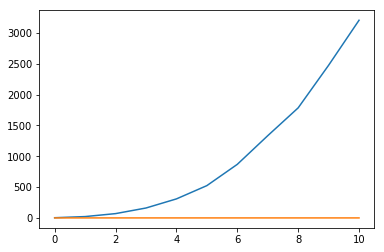

In [25]:
plt.plot(timeDense)
plt.plot(timeSparse)

In [3]:
# Some helping functions

# The Monte Carlo Simulation
def generateTrigoCohenAnsatz(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''
    # The decomposition of the stiffness matrix
    alpha = variables['alpha']
    
    # Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    # Space variables.
    spaceDiscr = parameter[1]
    
    # The covariance Operator
    eigV, eigF = variables['convOp']
    
    # The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    

    ### Frequent operators
    sqrtOp = sp.linalg.sqrtm(alpha.toarray())
    # C_h(k)
    cosOp = sp.linalg.cosm(sqrtOp*k)
    # S_h(k)
    sinOp = sp.linalg.sinm(sqrtOp*k)
    # \Lambda^{-1/2}
    LambdaNegPow = sp.linalg.inv(sqrtOp)
    # \Lambda^{1/2}
    LambdaPosPow = sqrtOp

    
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        u = np.dot(cosOp, uPast) + np.dot(LambdaNegPow, np.dot(sinOp, vPast)) \
               + np.dot(LambdaNegPow, np.dot(sinOp, uPast)) * (randomField[n, :] - randomField[n - 1, :])

        v = - np.dot(LambdaPosPow, np.dot(sinOp, uPast)) + np.dot(cosOp, vPast) \
               + np.dot(cosOp, uPast )* (randomField[n, :] - randomField[n - 1, :])
        
    
    shared_result_dict[parameter] = (u,v)




64.5010461807251


In [6]:
result

{}

In [29]:

# The Monte Carlo Simulation
def generateTrigoEigenvalueFuncBasisTransform(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''

    # The decomposition of the stiffness matrix
    eigs, eigfunc = variables['eigenDecompo']
    
    # Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    # Space variables.
    spaceDiscr = parameter[1]
    
    # The covariance Operator
    eigV, eigF = variables['convOp']
    
    # The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    
    
    # Some operator on the spectrum we will use.
    sink = lambda t : lambda x : np.sin( t*x**(1./2) )
    cosk = lambda t : lambda x : np.cos( t*x**(1./2) )
    Lambda = lambda s:  lambda x : x**(s)

    ### Frequent operators

    # C_h(k)
    cosOp = ssp.diags(cosk(k)(eigs)).tocsc()
    # S_h(k)
    sinOp = ssp.diags(sink(k)(eigs)).tocsc()
    # \Lambda^{-1/2}
    LambdaNegPow = ssp.diags(Lambda(-1./2)(eigs)).tocsc()
    # \Lambda^{1/2}
    LambdaPosPow = ssp.diags(Lambda(1./2)(eigs)).tocsc()

    
    # Let us first do the basis transformation
    y_1 = ((eigfunc.T).dot(u)).dot(eigfunc)
    y_2 = ((eigfunc.T).dot(v)).dot(eigfunc)
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        y_1Past = y_1
        y_2Past = y_2
        
        y_1 = cosOp.dot(y_1Past) + LambdaNegPow.dot( sinOp.dot(y_2Past)) \
               + LambdaNegPow.dot( sinOp.dot( y_1Past ))* (randomField[n, :] - randomField[n - 1, :])

        y_2 = - LambdaPosPow.dot( sinOp.dot(y_1Past)) + cosOp.dot(y_2Past) \
               + cosOp.dot(y_1Past)* (randomField[n, :] - randomField[n - 1, :])
        
    # And transformation back:
    u = ((eigfunc).dot(y_1)).dot(eigfunc.T)
    v = ((eigfunc).dot(y_2)).dot(eigfunc.T)
    
    shared_result_dict[parameter] = (u,v)


In [ ]:
#plt.plot(resultCNM[dictkey][0])
#plt.plot(resultEUL[dictkey][0])
#plt.plot(resultSVD1[dictkey][0])
#plt.plot(resultSVD2[dictkey][0])
#plt.plot(resultEXP[dictkey][0])
#plt.plot(resultEigValDecBasTra[dictkey][0])
#plt.plot(resultEigValDec[dictkey][0])
#plt.plot(resultCohenFull[dictkey][0])
#plt.plot(resultCohenLumped[dictkey][0])
#print(resultSVD.keys())

#print(timeAnalysis)

spaceDiscr = 1000
A = generateStiffness(spaceDiscr)
# Now the mass Lumped:
#MLumpedInv = generateSumLumpedMassMatrixInv(spaceDiscr)
#alphaLumped = MLumpedInv.dot(A)

dum = np.zeros(spaceDiscr)
dum[2] = 1
dum[48] = 45
Afull = A.toarray()

#now = time.time()
#A.dot(dum)
#print(time.time()-now)

#now = time.time()
#Afull.dot(dum)
#print(time.time()-now)
timeDense = []
timeSparse = []


for i in [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000]:
    A = generateStiffness(i)
    
    now = time.time()
    Afull = A.toarray()
    print(time.time() -now)
    randomVec = np.array(range(i))

    
    now = time.time()
    ssp.linalg.spsolve(A, randomVec)
    timeSparse.append(time.time()-now)
    
    now = time.time()
    np.linalg.solve(Afull, randomVec)
    timeDense.append(time.time()-now)



0.6154592037200928
2.457551956176758
5.484883546829224


In [21]:
# Some helping functions


# The Monte Carlo Simulation
def generateTrigoEigenDecompo(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''
    # The decomposition of the stiffness matrix
    eigs, eigfunc = variables['eigenDecompo']
    
    # Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    # Space variables.
    spaceDiscr = parameter[1]
    
    # The covariance Operator
    eigV, eigF = variables['convOp']
    
    # The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    
    
    # Some concrete functions we might need:
    abstrLamb = lambda Q, s, QT, func, vec : np.dot( np.dot(Q, np.dot(np.diag(func(s)), QT)) , vec)
    # Some operator on the spectrum we will use.
    sink = lambda t : lambda x : np.sin( t*x**(1./2) )
    cosk = lambda t : lambda x : np.cos( t*x**(1./2) )
    Lambda = lambda s:  lambda x : x**(s)

    ### Frequent operators

    # C_h(k)
    cosOp = np.dot(eigfunc, np.dot(np.diag(cosk(k)(eigs)), eigfunc.T))
    # S_h(k)
    sinOp = np.dot(eigfunc, np.dot(np.diag(sink(k)(eigs)), eigfunc.T))
    # \Lambda^{-1/2}
    LambdaNegPow = np.dot(eigfunc, np.dot(np.diag(Lambda(-1. / 2)(eigs)), eigfunc.T))
    # \Lambda^{1/2}
    LambdaPosPow = np.dot(eigfunc, np.dot(np.diag(Lambda(1. / 2)(eigs)), eigfunc.T))

    
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        u = np.dot(cosOp, uPast) + np.dot(LambdaNegPow, np.dot(sinOp, vPast)) \
               + np.dot(LambdaNegPow, np.dot(sinOp, uPast)) * (randomField[n, :] - randomField[n - 1, :])

        v = - np.dot(LambdaPosPow, np.dot(sinOp, uPast)) + np.dot(cosOp, vPast) \
               + np.dot(cosOp, uPast )* (randomField[n, :] - randomField[n - 1, :])
        
    
    shared_result_dict[parameter] = (u,v)





# The Explicite Euler Method
def generateTrajectoriesCrankNicolsonMaruyama(parameter, variables, shared_result_dict):
    '''
    This is the Crank-Nicolson-Maruyama method to generate the endpoint in time of trajectories of 
	wave equation with multiplicative nose.
	1) The parameter is of the form
	parameter = (timeMax,
		spaceDiscr,
		timeDiscr,
		noiseSeed,
		noiseSmoothParam,
		initialCondByName,
		'LaplaceCovarianceOp')
	2) In variables we give the initial condition, the covariance operator by eigenvalues
	and eigenfunctions and the \alpha operator for the particular setting
	returns two vectors, which represent the trajectories at the end time point.
    '''

    # The alpha operator with the Lumped Mass matrix
    alpha = variables['alphaLumped']
    
    ## Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    ## Space variables.
    spaceDiscr = parameter[1]
    
    ## The covariance Operator
    eigV, eigF = variables['convOp']
    
    ## The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
 
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        
        # The noise term is.
        deltaW = (randomField[n, :] - randomField[n - 1, :])
        
        # RHS for the second component is:
        rhsVSolve = vPast - k* alpha.dot(uPast) - (k/2.)**2 * alpha.dot(vPast) + uPast*deltaW
        
        v = ssp.linalg.spsolve(ssp.identity(spaceDiscr) + (k/2.)**2 * alpha, rhsVSolve)
        
        u = uPast + (k/2.)*(v + vPast)
        
        plt.plot(np.linspace(1,0,spaceDiscr), u)
        
        
    plt.savefig('currentTrajCNM' + str(n) + '.png')
    
    shared_result_dict[parameter] = (u,v)

    



# The random setting
def GenBrownianMotion(eigV, eigF, M, N, J, timeMax,  seed=0):
    '''
    This generates a matrix randomField of shape (M+1)x(N) so that for j = 1,...,M
                randomField[j,:]
    is the values of a Wiener process due to the given covariance operator for the timestep timeMax*j/M.

    param: eigV: lambda function for the eigenvalues of the covariance operator.
    param: eigF: eigenfunctions of the covariance operator.
    param: M: Number of time discretizations.
    param: N: Number of spatial discretizations.
    param: J: Number of the truncations
    param: seed:
    '''
    randomField = np.zeros((M+1,N))
    if seed != 0:
        np.random.seed(seed=seed)

    # Let's generate J standard brownian motion trajectories on the time interval (0, timeMax)
    brownianMotions = np.zeros((J,M+1))
    for j in range(J):
        for i in range(M):
            # scale is the standard deviation.
            brownianMotions[j,i+1] = brownianMotions[j,i] + norm.rvs(scale=math.sqrt(timeMax/M*1.))

    # Let's generate the whole random field.
    # Time
    for m in range(M+1):
        # Space
        for n in range(N):
            # 'complexity'
            # We just sum over the noise values.
            tempValue = 0.
            for k in range(J):
                # The point in space
                x_n = (n+1)/(N+1)
                
                # We just sum over the noise values.
                tempValue = tempValue + math.sqrt(eigV(k+1)) * eigF(k+1)(x_n) * brownianMotions[k,m]
            
            
            randomField[m,n] = tempValue

    return randomField


# The stiffness matrix
def generateStiffness(N):
    # We will just give the stiffness matrix explicite for the particular example.
    # The source of this definition is Strong and Weak Approximation of Semilinear Stochastic Evolution Equations
    # From Raphael Kruse
    A = ssp.csc_matrix((N,N))
    h = 1./(N+1)
    
    # We give it just explicite

    for i in range(N):
        for j in range(N):
            if i == j:
                A[i,j] = 2/h
            elif abs(i-j) == 1:
                A[i,j] = -1/h
            else:
                pass
    return A

def generateMassMatrix(N):
    # We will just give the mass matrix explicite for the particular example.
    # The source of this definition is Strong and Weak Approximation of Semilinear Stochastic Evolution Equations
    # From Raphael Kruse
    M = ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    for i in range(N):
        for j in range(N):
            if i == j:
                M[i,j] = 2*h/3
            elif abs(i-j) == 1:
                M[i,j] = h/6
            else:
                pass
    M = M.tocsc()
    return M

def generateSumLumpedMassMatrix(N):
    
    M= ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    for i in range(N):
        if i!=0 and i!=N-1:
            M[i,i] = h
        elif i==0 or i==N-1:
            M[i,i] = h*5/6
    
    M = M.tocsc()
    
    return M



def generateSumLumpedMassMatrixInv(N):
    
    M= ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    for i in range(N):
        if i!=0 and i!=N-1:
            M[i,i] = 1/h
        elif i==0 or i==N-1:
            M[i,i] = (h*5/6)**(-1)
    M = M.tocsc()
    return M

def numberToString(number, lenght):
    '''
    Number is the value given. Length denotes the length of the ouput string.
    we expect, that 
    '''
    nString  = str(number)
    if len(nString) < length:
        # Add zeros at the beginning
        for i in range(length - len(nString)):
            nString = '0' + nString
    else:
        # Cut off the end
        nString = nString[:length]

    return nString

def calculateTrajectories(parameter):
    '''
    Calculates trajectories with the given parameter setting.
    :param: parameter: just all parameters
    :returs: A dictionary with the given trajectories and the corresponding parameters
    '''
    # First we give an dictionary for the results
    manager = multiprocessing.Manager()
    result_dict = manager.dict()

    tempVariables = {}

    # Current parameter setting.


    ###########################
    ##### Space parameter #####
    ###########################
    for spaceDiscr in parameter['spaceDiscr']:
        
        
        ############################
        #### Noise Smoothness ######
        ############################
        for noiseSmoothParam in parameter['noiseSmoothParam']:
            #####################################
            ##### The covariance operator #######
            #####################################

            for covarianceOpByName in parameter['covarianceOpByName']:
                # The covariance operator, given by explice eigenvalues and eigenfunctions as lambda functions.
                if covarianceOpByName == 'LaplaceCovarianceOp':

                    ### Color for the noise. These are the eigenvalues and eigenfunctions of (-\Delta)^{-s}, where \Delta is the laplacian.
                    eigV = lambda s :lambda j : (j* math.pi)**(-s*2)
                    eigF = lambda j : lambda y: math.sqrt(2)*np.sin(j * math.pi * y)
                else:
                    raise NameError('No covariance operator given')

                tempVariables['convOp'] = (eigV(noiseSmoothParam), eigF)
                
                ###################################### 
                ##### The initial condition loop #####
                ######################################
                for initialCondByName in parameter['initialCondByName']:

                        #### The initial condition #####
                    if initialCondByName == 'eigenFunctionInitCondition':
                        # A very smooth init condition
                        h=1./(spaceDiscr + 1)
                        u_0 = np.sin(2 * math.pi * np.linspace(h,1-h, spaceDiscr))
                        v_0 = np.sin(3 * math.pi * np.linspace(h,1-h, spaceDiscr))
                    elif initialCondByName == 'unsmoothInitCond':
                        # A very unsmooth init condition
                        u_0 = np.concatenate((np.linspace(0, 5, np.floor((spaceDiscr) / 4.)), np.linspace(5, 0, np.floor((spaceDiscr) / 4)),
                                          np.zeros(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.)))))  # in H^1
                        # So this is just the weak derivative of u_0
                        v_0 = np.concatenate((np.full(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.)), 0),
                                                np.full(int(np.floor((spaceDiscr) / 4.)), 5. ),
                                                np.full( int(np.floor((spaceDiscr) / 4.)), 0)))  # in H^0
                    else:
                        raise NameError('No initial condition given')

                    tempVariables['initVals'] = [u_0, v_0]


                    #############################
                    ##### Time parameter ########
                    #############################
                    for timeDiscr in parameter['timeDiscr']:
                        #####################
                        ##### Time Max ######
                        #####################
                        for timeMax in parameter['timeMax']:

                            # We prepare the last prameter before sending the Monte Carlo iterations:
                            targetFunc = None
                            # We assign the target function per algorithm.
                            if parameter['methodByName'] == 'trigonometricSVD':
                                # The trigonomtric method with sigular value decomposition.
                                targetFunc = generateTrigonometricTrajectoriesMonteCarloBasisTransform
                                # We take the alpha full:
                                # First the general alpha
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alphaFull'] = alphaFull
                                # Now the docomposition of alphaFull
                                Q, sigma, QT = np.linalg.svd(alphaFull.toarray(), full_matrices=True)
                                tempVariables['alphaOperDecomp'] = (Q, sigma, QT)


                            elif parameter['methodByName'] == 'trigonemtricExp':
                                # The trigonometric method with build in exponent function.
                                targetFunc = generateTrajectoriesWithBuildInExp
                            elif parameter['methodByName'] == 'expliciteEuler':
                                # The explicite Euler Method.
                                targetFunc = generateTrajectoriesEulerMethod
                            elif parameter['methodByName'] == 'trigonometricSVDWithoutBT':
                                # The tridonometric Method with the SVD of alpha, but not basis transformation.
       
                                targetFunc = generateTrigonometricTrajectoriesMonteCarlo
                                # First the alpha.
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alphaFull'] = alphaFull
                                
                                # Now the docomposition of alphaFull
                                Q, sigma, QT = np.linalg.svd(alphaFull.toarray(), full_matrices=True)
                                tempVariables['alphaOperDecomp'] = (Q, sigma, QT)
                                
                            elif parameter['methodByName'] == 'CrankNicolson':
                                # The Crank-Nicolson-Maruyama method.
                                targetFunc = generateTrajectoriesCrankNicolsonMaruyama
                                A = generateStiffness(spaceDiscr)
                                # Now the mass Lumped:
                                MLumpedInv = generateSumLumpedMassMatrixInv(spaceDiscr)
                                alphaLumped = MLumpedInv.dot(A)
                                tempVariables['alphaLumped'] = alphaLumped

                                
                                                          
                                
                            ############################
                            ### The noise seed loop ####
                            ############################
                            ## Wee send all the processes due to a noise seed in parralel,
                            ## and wait until they are done.
                            
                            allProcesses = []
                            for noiseSeed in parameter['noiseSeed']:

                                ## We save the current parameter ####
                                tempParameter = (timeMax,
                                                 spaceDiscr,
                                                 timeDiscr,
                                                 noiseSeed,
                                                 noiseSmoothParam,
                                                 initialCondByName,
                                                 'LaplaceCovarianceOp')
                
                                    
                                # And we start the process
                                process = multiprocessing.Process(target=targetFunc, 
                                                                  args=(tempParameter, tempVariables, result_dict))
                                process.start()

                                allProcesses.append(process)
                                

                            # Lets wait untill all processes are done:
                            for process in allProcesses:
                                process.join()
    # Ok, done.
    return dict(result_dict)




In [110]:

# The Monte Carlo Simulation
def generateTrigonometricTrajectoriesMonteCarloBasisTransform(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''

    # The decomposition of the stiffness matrix
    Q, sigma, QT = variables['alphaOperDecomp']
    
    # Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    # Space variables.
    spaceDiscr = parameter[1]
    
    # The covariance Operator
    eigV, eigF = variables['convOp']
    
    # The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    
    
    # Some operator on the spectrum we will use.
    sink = lambda t : lambda x : np.sin( t*x**(1./2) )
    cosk = lambda t : lambda x : np.cos( t*x**(1./2) )
    Lambda = lambda s:  lambda x : x**(s)

    ### Frequent operators

    # C_h(k)
    cosOp = ssp.diags(cosk(k)(sigma)).tocsc()
    # S_h(k)
    sinOp = ssp.diags(sink(k)(sigma)).tocsc()
    # \Lambda^{-1/2}
    LambdaNegPow = ssp.diags(Lambda(-1./2)(sigma)).tocsc()
    # \Lambda^{1/2}
    LambdaPosPow = ssp.diags(Lambda(1./2)(sigma)).tocsc()

    
    # Let us first do the basis transformation
    y_1 = ((Q.T).dot(u))
    y_2 = ((Q.T).dot(v))
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        y_1Past = y_1
        y_2Past = y_2
        
        y_1 = cosOp.dot(y_1Past) + LambdaNegPow.dot( sinOp.dot(y_2Past)) \
               + LambdaNegPow.dot( sinOp.dot( y_1Past ))* (randomField[n, :] - randomField[n - 1, :])

        y_2 = - LambdaPosPow.dot( sinOp.dot(y_1Past)) + cosOp.dot(y_2Past) \
               + cosOp.dot(y_1Past)* (randomField[n, :] - randomField[n - 1, :])
        
    # And transformation back:
    u = ((Q).dot(y_1))
    v = ((Q).dot(y_2))
    
    shared_result_dict[parameter] = (u,v)


In [145]:
# Some helping functions


# The Monte Carlo Simulation
def generateTrigonometricTrajectoriesMonteCarlo(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''
    # The decomposition of the stiffness matrix
    Q, sigma, QT = variables['alphaOperDecomp']
    
    # Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    # Space variables.
    spaceDiscr = parameter[1]
    
    # The covariance Operator
    eigV, eigF = variables['convOp']
    
    # The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    
    
    # Some concrete functions we might need:
    abstrLamb = lambda Q, s, QT, func, vec : np.dot( np.dot(Q, np.dot(np.diag(func(s)), QT)) , vec)
    # Some operator on the spectrum we will use.
    sink = lambda t : lambda x : np.sin( t*x**(1./2) )
    cosk = lambda t : lambda x : np.cos( t*x**(1./2) )
    Lambda = lambda s:  lambda x : x**(s)

    ### Frequent operators

    # C_h(k)
    cosOp = np.dot(Q, np.dot(np.diag(cosk(k)(sigma)), QT))
    # S_h(k)
    sinOp = np.dot(Q, np.dot(np.diag(sink(k)(sigma)), QT))
    # \Lambda^{-1/2}
    LambdaNegPow = np.dot(Q, np.dot(np.diag(Lambda(-1. / 2)(sigma)), QT))
    # \Lambda^{1/2}
    LambdaPosPow = np.dot(Q, np.dot(np.diag(Lambda(1. / 2)(sigma)), QT))

    
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        u = np.dot(cosOp, uPast) + np.dot(LambdaNegPow, np.dot(sinOp, vPast)) \
               + np.dot(LambdaNegPow, np.dot(sinOp, uPast)) * (randomField[n, :] - randomField[n - 1, :])

        v = - np.dot(LambdaPosPow, np.dot(sinOp, uPast)) + np.dot(cosOp, vPast) \
               + np.dot(cosOp, uPast )* (randomField[n, :] - randomField[n - 1, :])
        
    
    shared_result_dict[parameter] = (u,v)





# The Explicite Euler Method
def generateTrajectoriesCrankNicolsonMaruyama(parameter, variables, shared_result_dict):
    '''
    This is the Crank-Nicolson-Maruyama method to generate the endpoint in time of trajectories of 
	wave equation with multiplicative nose.
	1) The parameter is of the form
	parameter = (timeMax,
		spaceDiscr,
		timeDiscr,
		noiseSeed,
		noiseSmoothParam,
		initialCondByName,
		'LaplaceCovarianceOp')
	2) In variables we give the initial condition, the covariance operator by eigenvalues
	and eigenfunctions and the \alpha operator for the particular setting
	returns two vectors, which represent the trajectories at the end time point.
    '''

    # The alpha operator with the Lumped Mass matrix
    alpha = variables['alphaLumped']
    
    ## Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    ## Space variables.
    spaceDiscr = parameter[1]
    
    ## The covariance Operator
    eigV, eigF = variables['convOp']
    
    ## The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
 
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        
        # The noise term is.
        deltaW = (randomField[n, :] - randomField[n - 1, :])
        
        # RHS for the second component is:
        rhsVSolve = vPast - k* alpha.dot(uPast) - (k/2.)**2 * alpha.dot(vPast) + uPast*deltaW
        
        v = ssp.linalg.spsolve(ssp.identity(spaceDiscr) + (k/2.)**2 * alpha, rhsVSolve)
        
        u = uPast + (k/2.)*(v + vPast)
        
        plt.plot(np.linspace(1,0,spaceDiscr), u)
        
        
    plt.savefig('currentTrajCNM' + str(n) + '.png')
    
    shared_result_dict[parameter] = (u,v)

    



# The random setting
def GenBrownianMotion(eigV, eigF, M, N, J, timeMax,  seed=0):
    '''
    This generates a matrix randomField of shape (M+1)x(N) so that for j = 1,...,M
                randomField[j,:]
    is the values of a Wiener process due to the given covariance operator for the timestep timeMax*j/M.

    param: eigV: lambda function for the eigenvalues of the covariance operator.
    param: eigF: eigenfunctions of the covariance operator.
    param: M: Number of time discretizations.
    param: N: Number of spatial discretizations.
    param: J: Number of the truncations
    param: seed:
    '''
    randomField = np.zeros((M+1,N))
    if seed != 0:
        np.random.seed(seed=seed)

    # Let's generate J standard brownian motion trajectories on the time interval (0, timeMax)
    brownianMotions = np.zeros((J,M+1))
    for j in range(J):
        for i in range(M):
            # scale is the standard deviation.
            brownianMotions[j,i+1] = brownianMotions[j,i] + norm.rvs(scale=math.sqrt(timeMax/M*1.))

    # Let's generate the whole random field.
    # Time
    for m in range(M+1):
        # Space
        for n in range(N):
            # 'complexity'
            # We just sum over the noise values.
            tempValue = 0.
            for k in range(J):
                # The point in space
                x_n = (n+1)/(N+1)
                
                # We just sum over the noise values.
                tempValue = tempValue + math.sqrt(eigV(k+1)) * eigF(k+1)(x_n) * brownianMotions[k,m]
            
            
            randomField[m,n] = tempValue

    return randomField


# The stiffness matrix
def generateStiffness(N):
    # We will just give the stiffness matrix explicite for the particular example.
    # The source of this definition is Strong and Weak Approximation of Semilinear Stochastic Evolution Equations
    # From Raphael Kruse
    A = ssp.csc_matrix((N,N))
    h = 1./(N+1)
    
    # We give it just explicite

    for i in range(N):
        for j in range(N):
            if i == j:
                A[i,j] = 2/h
            elif abs(i-j) == 1:
                A[i,j] = -1/h
            else:
                pass
    return A

def generateMassMatrix(N):
    # We will just give the mass matrix explicite for the particular example.
    # The source of this definition is Strong and Weak Approximation of Semilinear Stochastic Evolution Equations
    # From Raphael Kruse
    M = ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    for i in range(N):
        for j in range(N):
            if i == j:
                M[i,j] = 2*h/3
            elif abs(i-j) == 1:
                M[i,j] = h/6
            else:
                pass
    M = M.tocsc()
    return M

def generateSumLumpedMassMatrix(N):
    
    M= ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    for i in range(N):
        if i!=0 and i!=N-1:
            M[i,i] = h
        elif i==0 or i==N-1:
            M[i,i] = h*5/6
    
    M = M.tocsc()
    
    return M



def generateSumLumpedMassMatrixInv(N):
    
    M= ssp.lil_matrix((N,N))
    h = 1./(N+1)
    
    for i in range(N):
        if i!=0 and i!=N-1:
            M[i,i] = 1/h
        elif i==0 or i==N-1:
            M[i,i] = (h*5/6)**(-1)
    M = M.tocsc()
    return M

def numberToString(number, lenght):
    '''
    Number is the value given. Length denotes the length of the ouput string.
    we expect, that 
    '''
    nString  = str(number)
    if len(nString) < length:
        # Add zeros at the beginning
        for i in range(length - len(nString)):
            nString = '0' + nString
    else:
        # Cut off the end
        nString = nString[:length]

    return nString

def calculateTrajectories(parameter):
    '''
    Calculates trajectories with the given parameter setting.
    :param: parameter: just all parameters
    :returs: A dictionary with the given trajectories and the corresponding parameters
    '''
    # First we give an dictionary for the results
    manager = multiprocessing.Manager()
    result_dict = manager.dict()

    tempVariables = {}

    # Current parameter setting.


    ###########################
    ##### Space parameter #####
    ###########################
    for spaceDiscr in parameter['spaceDiscr']:
        
        
        ############################
        #### Noise Smoothness ######
        ############################
        for noiseSmoothParam in parameter['noiseSmoothParam']:
            #####################################
            ##### The covariance operator #######
            #####################################

            for covarianceOpByName in parameter['covarianceOpByName']:
                # The covariance operator, given by explice eigenvalues and eigenfunctions as lambda functions.
                if covarianceOpByName == 'LaplaceCovarianceOp':

                    ### Color for the noise. These are the eigenvalues and eigenfunctions of (-\Delta)^{-s}, where \Delta is the laplacian.
                    eigV = lambda s :lambda j : (j* math.pi)**(-s*2)
                    eigF = lambda j : lambda y: math.sqrt(2)*np.sin(j * math.pi * y)
                else:
                    raise NameError('No covariance operator given')

                tempVariables['convOp'] = (eigV(noiseSmoothParam), eigF)
                
                ###################################### 
                ##### The initial condition loop #####
                ######################################
                for initialCondByName in parameter['initialCondByName']:

                        #### The initial condition #####
                    if initialCondByName == 'eigenFunctionInitCondition':
                        # A very smooth init condition
                        h=1./(spaceDiscr + 1)
                        u_0 = np.sin(2 * math.pi * np.linspace(h,1-h, spaceDiscr))
                        v_0 = np.sin(3 * math.pi * np.linspace(h,1-h, spaceDiscr))
                    elif initialCondByName == 'unsmoothInitCond':
                        # A very unsmooth init condition
                        u_0 = np.concatenate((np.linspace(0, 5, np.floor((spaceDiscr) / 4.)), np.linspace(5, 0, np.floor((spaceDiscr) / 4)),
                                          np.zeros(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.)))))  # in H^1
                        # So this is just the weak derivative of u_0
                        v_0 = np.concatenate((np.full(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.)), 0),
                                                np.full(int(np.floor((spaceDiscr) / 4.)), 5. ),
                                                np.full( int(np.floor((spaceDiscr) / 4.)), 0)))  # in H^0
                    else:
                        raise NameError('No initial condition given')

                    tempVariables['initVals'] = [u_0, v_0]


                    #############################
                    ##### Time parameter ########
                    #############################
                    for timeDiscr in parameter['timeDiscr']:
                        #####################
                        ##### Time Max ######
                        #####################
                        for timeMax in parameter['timeMax']:

                            # We prepare the last prameter before sending the Monte Carlo iterations:
                            targetFunc = None
                            # We assign the target function per algorithm.
                            if parameter['methodByName'] == 'trigonometricSVD':
                                # The trigonomtric method with sigular value decomposition.
                                targetFunc = generateTrigonometricTrajectoriesMonteCarloBasisTransform
                                # We take the alpha full:
                                # First the general alpha
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alphaFull'] = alphaFull
                                # Now the docomposition of alphaFull
                                Q, sigma, QT = np.linalg.svd(alphaFull.toarray(), full_matrices=True)
                                tempVariables['alphaOperDecomp'] = (Q, sigma, QT)


                            elif parameter['methodByName'] == 'trigonemtricExp':
                                # The trigonometric method with build in exponent function.
                                targetFunc = generateTrajectoriesWithBuildInExp
                            elif parameter['methodByName'] == 'expliciteEuler':
                                # The explicite Euler Method.
                                targetFunc = generateTrajectoriesEulerMethod
                            elif parameter['methodByName'] == 'trigonometricSVDWithoutBT':
                                # The tridonometric Method with the SVD of alpha, but not basis transformation.
       
                                targetFunc = generateTrigonometricTrajectoriesMonteCarlo
                                # First the alpha.
                                A = generateStiffness(spaceDiscr)
                                MFull = generateMassMatrix(spaceDiscr)
                                MFullinv = ssp.linalg.inv(MFull)
                                alphaFull = MFullinv.dot(A)

                                tempVariables['alphaFull'] = alphaFull
                                
                                # Now the docomposition of alphaFull
                                Q, sigma, QT = np.linalg.svd(alphaFull.toarray(), full_matrices=True)
                                tempVariables['alphaOperDecomp'] = (Q, sigma, QT)
                                
                            elif parameter['methodByName'] == 'CrankNicolson':
                                # The Crank-Nicolson-Maruyama method.
                                targetFunc = generateTrajectoriesCrankNicolsonMaruyama
                                A = generateStiffness(spaceDiscr)
                                # Now the mass Lumped:
                                MLumpedInv = generateSumLumpedMassMatrixInv(spaceDiscr)
                                alphaLumped = MLumpedInv.dot(A)
                                tempVariables['alphaLumped'] = alphaLumped

                                
                                                          
                                
                            ############################
                            ### The noise seed loop ####
                            ############################
                            ## Wee send all the processes due to a noise seed in parralel,
                            ## and wait until they are done.
                            
                            allProcesses = []
                            for noiseSeed in parameter['noiseSeed']:

                                ## We save the current parameter ####
                                tempParameter = (timeMax,
                                                 spaceDiscr,
                                                 timeDiscr,
                                                 noiseSeed,
                                                 noiseSmoothParam,
                                                 initialCondByName,
                                                 'LaplaceCovarianceOp')
                
                                    
                                # And we start the process
                                process = multiprocessing.Process(target=targetFunc, 
                                                                  args=(tempParameter, tempVariables, result_dict))
                                process.start()

                                allProcesses.append(process)
                                

                            # Lets wait untill all processes are done:
                            for process in allProcesses:
                                process.join()
    # Ok, done.
    return dict(result_dict)




In [56]:
# This takes very long!!!

if __name__ == '__main__':
    # Import all necessary modules
    parameterSetting = 'parameterReferenceTrajSmooth'
    
    # The initial values
    if parameterSetting == 'parameterNoiseAnalysisSmooth':
        # Noise analysis with with smooth inital condition
        parameter = {'timeMax' : [10.],
                             'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8])),
                             # 'spaceDiscr' : 2**(np.array([2,3])),
                             'timeDiscr' : [2**9],
                             'noiseSeed' : range(1,2501),
                             'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                             'initialCondByName': ['eigenFunctionInitCondition'],
                             'covarianceOpByName': ['LaplaceCovarianceOp'],
                             'methodByName': ['trigonometric'],
                             'fileName': 'simulationExperimentConvergenceRate_Smooth_Init_Cond_NoiseAnalysis.p'}
        
    
    elif parameterSetting == 'parameterTimeConvergenceSmooth':
        # Time Convergence with smooth init condition
        parameter = {'timeMax' : [10.],
                             'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8])),
                             # 'spaceDiscr' : 2**(np.array([2,3])),
                             'timeDiscr' : [2**9],
                             'noiseSeed' : range(1,2501),
                             'noiseSmoothParam': [1/2],
                             'initialCondByName': ['eigenFunctionInitCondition'],
                             'covarianceOpByName': ['LaplaceCovarianceOp'],
                             'methodByName': ['trigonometric'],
                             'fileName': 'simulationExperimentConvergenceRate_Smooth_Init_Cond_TimeAnalysis.p'}
        
    elif parameterSetting == 'parameterReferenceTrajSmooth':
        # To generate the reference trajectories in the smooth case
        parameter = {'timeMax' : [10.],
                             'spaceDiscr' : 2**(np.array([9])),
                             # 'spaceDiscr' : 2**(np.array([2,3])),
                             'timeDiscr' : [2**5],
                             'noiseSeed' : range(1,2),
                             'noiseSmoothParam': [1/2],
                             'initialCondByName': ['eigenFunctionInitCondition'],
                             'covarianceOpByName': ['LaplaceCovarianceOp'],
                             'methodByName': ['trigonometric'],
                             'fileName': 'simulationExperimentConvergenceRate_Smooth_Init_Cond_RefTrajectories.p'}
    elif parameterSetting == 'parameterNoiseAnalysisUnSmooth':
        # Analysis of the influence of the noise in the Unsmooth setting
        parameter = {'timeMax' : [10.],
                             'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8])),
                             # 'spaceDiscr' : 2**(np.array([2,3])),
                             'timeDiscr' : [2**9],
                             'noiseSeed' : range(1,2501),
                             'noiseSmoothParam': [1/2],
                             'initialCondByName': ['unsmoothInitCond'],
                             'covarianceOpByName': ['LaplaceCovarianceOp'],
                             'methodByName': ['trigonometric'],
                             'fileName': 'simulationExperimentConvergenceRate_UnSmooth_Init_Cond_NoiseAnalysis.p'}
    elif parameterSetting == 'parameterTimeConvergenceUnSmooth':
        # Time Convergence in the Unsmooth setting    
        parameter = {'timeMax' : [10.],
                             'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8])),
                             # 'spaceDiscr' : 2**(np.array([2,3])),
                             'timeDiscr' : [2**9],
                             'noiseSeed' : range(1,2501),
                             'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                             'initialCondByName': ['unsmoothInitCond'],
                             'covarianceOpByName': ['LaplaceCovarianceOp'],
                             'methodByName': ['trigonometric'],
                             'fileName': 'simulationExperimentConvergenceRate_UnSmooth_Init_Cond_TimeAnalysis.p'}
    elif parameterSetting == 'parameterReferenceTrajUnSmooth':
        # Calculating the reference trajectories in the unsmooth setting.
        parameter = {'timeMax' : [10.],
                             'spaceDiscr' : 2**(np.array([9])),
                             # 'spaceDiscr' : 2**(np.array([2,3])),
                             'timeDiscr' : [2**9],
                             'noiseSeed' : range(1,2501),
                             'noiseSmoothParam': [1/2],
                             'initialCondByName': ['unsmoothInitCond'],
                             'covarianceOpByName': ['LaplaceCovarianceOp'],
                             'methodByName': ['trigonometric'],
                             'fileName': 'simulationExperimentConvergenceRate_UnSmooth_Init_Cond_RefTrajectories.p'}
    
    
    
     # Noise analysis with with smooth inital condition
    parameter = {'timeMax' : [10.],
                             'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8])),
                             # 'spaceDiscr' : 2**(np.array([2,3])),
                             'timeDiscr' : [2**9],
                             'noiseSeed' : range(1,2501),
                             'noiseSmoothParam': [1, 1/2, 1/3, 1/4],
                             'initialCondByName': ['eigenFunctionInitCondition'],
                             'covarianceOpByName': ['LaplaceCovarianceOp'],
                             'methodByName': ['trigonometric'],
                             'fileName': 'simulationExperimentConvergenceRate_Smooth_Init_Cond_NoiseAnalysis.p'}
        
    now = time.time()
    result = calculateTrajectories(parameter)

    time_analysis_file = open('time_analysis.txt', 'w')
    time_analysis_file.write('Claclulating ' + str(parameter) + ' took ' + str(time.time() - now) + ' s')
    print('Claclulating '+str(parameter)+ ' took ' + str(time.time() - now) + ' s')
    time_analysis_file.close()

    print(len(result))
    
    pickle.dump(result, open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'wb'))
    


/home/thomas_schnake/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Claclulating {'timeMax': [10.0], 'spaceDiscr': array([512]), 'timeDiscr': [32], 'noiseSeed': range(1, 2), 'noiseSmoothParam': [0.5], 'initialCondByName': ['eigenFunctionInitCondition'], 'covarianceOpByName': ['LaplaceCovarianceOp'], 'methodByName': ['trigonometric'], 'fileName': 'simulationExperimentConvergenceRate_Smooth_Init_Cond_RefTrajectories.p'} took 30.230260848999023 s
1


In [61]:

# Generate Trajectories
def generateTrajectoriesWithBuildInExp(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''

    # The Lumped alpha Matrix:
    alpha = variables['alphaFull']
    
    
    # Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    # Space variables.
    spaceDiscr = parameter[1]
    
    # The covariance Operator
    eigV, eigF = variables['convOp']
    
    # The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    
    # The initial vector in one 2*N vector.
    U = np.concatenate((u,v))
    
    # The matrix which we put to the exponent.
    AMat = ssp.lil_matrix((2*spaceDiscr, 2*spaceDiscr))

    AMat[:spaceDiscr, spaceDiscr:] = np.identity(spaceDiscr)
    AMat[spaceDiscr:, :spaceDiscr] = - alpha
    
    AMat.tocsc()
    
    
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1):
        
        UPast = U
        
        U = ssp.linalg.expm(k*AMat).dot(UPast) + ssp.linalg.expm(k*AMat).dot(np.concatenate((np.zeros(spaceDiscr), UPast[:spaceDiscr]))) \
                *np.concatenate((randomField[n, :] - randomField[n - 1, :], randomField[n, :] - randomField[n - 1, :]))
        
        plt.plot(np.linspace(1,0,spaceDiscr), U[:spaceDiscr])
    
    plt.savefig('currentTrajEXP' + str(n) + '.png')
    u = U[:spaceDiscr]
    v = U[spaceDiscr:]
    
    shared_result_dict[parameter] = (u,v)


In [137]:
# The Explicite Euler Method
def generateTrajectoriesEulerMethod(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''
    # The alpha operator with the Lumped Mass matrix
    alpha = variables['lumpedMassAlpha']
    
    ## Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    ## Space variables.
    spaceDiscr = parameter[1]
    
    ## The covariance Operator
    eigV, eigF = variables['convOp']
    
    ## The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        
        u = (1+k)*uPast

        v =  vPast - k *alpha.dot(uPast) + uPast*(randomField[n, :] - randomField[n - 1, :])
    
    
    shared_result_dict[parameter] = (u,v)

    


(10.0, 512, 32, 1, 0.5, 'eigenFunctionInitCondition', 'LaplaceCovarianceOp')


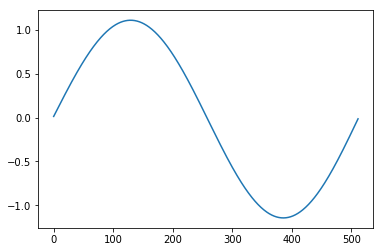

In [57]:
result = pickle.load(open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/'+parameter['fileName'], 'rb'))



N = parameter['spaceDiscr'][0]
s = parameter['noiseSmoothParam'][0]
noiseSeed = parameter['noiseSeed'][0]
timeMax =parameter['timeMax'][0]
timeDiscr = parameter['timeDiscr'][0]
initialCondByName = 'eigenFunctionInitCondition'
covarianceOpByName = 'LaplaceCovarianceOp'

for i in result.keys():
    print(i)
x2 = result[(timeMax, N, timeDiscr,  noiseSeed,s, initialCondByName, covarianceOpByName)][0]



plt.plot(x2)

In [65]:
#### Let us compare the semigroups:
## Note that this is NOT sparse!!!

N = 2
M = 100
k=1./M
LumpedMass = False

# We prepare the alpha
if not LumpedMass:
    M_h = generateMassMatrix(N).toarray()
    A_h = generateStiffness(N).toarray()
    M_hInv = np.linalg.inv(M_h)

alpha = np.dot(M_hInv, A_h)

AMat = np.zeros((2*N, 2*N))

AMat[:N, N:] = np.identity(N)
AMat[N:, :N] = - alpha
    

# 1) Explicie Euler Semi-Group
E_ExpEuler = np.identity(2*N) + k*AMat

# 2) Perkowskis Semi-Group
E_Per = sp.linalg.expm(k * AMat)

# 3) My fancy trigonometric method
Q, D, QT = np.linalg.svd(alpha)
# Some operator on the spectrum we will use.
sink = lambda t : lambda x : np.sin( t*x**(1./2) )
cosk = lambda t : lambda x : np.cos( t*x**(1./2) )
Lambda = lambda s:  lambda x : x**(s)

C_h = Q.dot(np.diag(cosk(k)(D)).dot(QT))
S_h = Q.dot(np.diag(sink(k)(D)).dot(QT))
Lambd1 = Q.dot(np.diag(Lambda(1/2)(D)).dot(QT))
Lambd2 = Q.dot(np.diag(Lambda(-1/2)(D)).dot(QT))

E_MyTrig = np.zeros((2*N,2*N))
# Now slicing:
E_MyTrig[:N,:N] = C_h
E_MyTrig[:N, N:] = Lambd2.dot(S_h)
E_MyTrig[N:, :N] = - Lambd1.dot(S_h)
E_MyTrig[N:, N:] = C_h






/home/thomas_schnake/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [67]:
spaceDiscr = N

u_0 = np.concatenate((np.linspace(0, 5, np.floor((spaceDiscr) / 4.)), np.linspace(5, 0, np.floor((spaceDiscr) / 4)), 
                      np.zeros(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.))))) 
v_0 = np.concatenate((np.full(int((spaceDiscr) - 2 * np.floor((spaceDiscr) / 4.)), 0),
                                                np.full(int(np.floor((spaceDiscr) / 4.)), 5. ),
                                                np.full( int(np.floor((spaceDiscr) / 4.)), 0)))  

# One step with Euler
U_0 = np.concatenate((u_0,v_0))

uEuler = E_ExpEuler.dot(U_0)

uMyTri = E_MyTrig.dot(U_0)

np.allclose(E_Per,E_MyTrig)


/home/thomas_schnake/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


True

In [ ]:
########## THIS IS NOT DONE YET ##########

# Trajectories with the eigenvalue Decompo
def generateTrajectoriesExpliciteEigenDecompo(parameter, variables, shared_result_dict):
    '''
    returns two vectors.
    '''
    # We load the mass matrix.
    M = parameter['MassMatrix']
    
    # Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    # Space variables.
    spaceDiscr = parameter[1]
    
    # The covariance Operator
    eigV, eigF = variables['convOp']
    
    # The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
    
    
    # The eigenvalues:
    lambda_hj = lambda j: 4*(N+1)**2 *(np.sin(j*math.pi/2(N+1)))**2
    # The eigenfunctions:
    e_hj = lambda j: lambda x: math.sqrt(2) * np.sin(j*pi*x)
    
    
    # Some some frequent vectors wich depend on space:
    for i in range(spaceDiscr):
        u

    ### Frequent operators

    # C_h(k)
    cosOp = ssp.diags(cosk(k)(sigma))
    # S_h(k)
    sinOp = ssp.diags(sink(k)(sigma))
    # \Lambda^{-1/2}
    LambdaNegPow = ssp.diags(Lambda(-1./2)(sigma))
    # \Lambda^{1/2}
    LambdaPosPow = ssp.diags(Lambda(1./2)(sigma))

    
    # Let us first do the basis transformation
    y_1 = np.dot(QT,u)
    y_2 = np.dot(QT,v)
    
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = y_1
        vPast = y_2
        
        y_1 = cosOp.dot(uPast) + LambdaNegPow.dot( sinOp.dot( vPast)) \
               + LambdaNegPow.dot( sinOp.dot( uPast * (randomField[n, :] - randomField[n - 1, :])))

        y_2 = - LambdaPosPow.dot( sinOp.dot(uPast)) + cosOp.dot(vPast) \
               + cosOp.dot(uPast * (randomField[n, :] - randomField[n - 1, :]))
        
    # And transformation back:
    u = np.dot(Q, y_1)
    v = np.dot(Q, y_2)
    
    shared_result_dict[parameter] = (u,v)



In [4]:
# The Explicite Euler Method
def generateTrajectoriesEulerMethod(parameter, variables, shared_result_dict):
    '''
    This is the Euler method to generate the endpoint in time of trajectories of 
	wave equation with multiplicative nose.
	1) The parameter is of the form
	parameter = (timeMax,
		spaceDiscr,
		timeDiscr,
		noiseSeed,
		noiseSmoothParam,
		initialCondByName,
		'LaplaceCovarianceOp')
	2) In variables we give the initial condition, the covariance operator by eigenvalues
	and eigenfunctions and the \alpha operator for the particular setting
	returns two vectors, which represent the trajectories at the end time point.
    '''

    # The alpha operator with the Lumped Mass matrix
    alpha = variables['alphaLumped']
    
    ## Time variables
    timeDiscr = parameter[2]
    Tmax = parameter[0]
    k = Tmax/timeDiscr
    
    ## Space variables.
    spaceDiscr = parameter[1]
    
    ## The covariance Operator
    eigV, eigF = variables['convOp']
    
    ## The noise seed
    noiseSeed = parameter[3]
    
    ## The random field ##
    randomField = GenBrownianMotion(eigV,
                                    eigF,
                                    timeDiscr,
                                    spaceDiscr,
                                    spaceDiscr +1,
                                    Tmax,
                                    noiseSeed)
    
    
    
    # Starting with the initial condition
    u = variables['initVals'][0]
    v = variables['initVals'][1]
 
    ### Let's iterate. ###
    for n in range(1,timeDiscr+1): # Not at time 0
        # Saving the temporal step
        uPast = u
        vPast = v
        
        u = uPast + k*vPast

        v = vPast - k *alpha.dot(uPast) + uPast*(randomField[n, :] - randomField[n - 1, :])
    
    
    shared_result_dict[parameter] = (u,v)

    


In [134]:
N = 4

stiff = generateStiffness(N)
mass = generateSumLumpedMassMatrix(N)
massInv = ssp.linalg.inv(mass)

alpha= massInv.dot(stiff)

A = ssp.csc_matrix((2*N, 2*N))

A[:N,N:] = np.identity(N)
A[N:, :N] = - alpha

ssp.linalg.expm(A).toarray()


/home/thomas_schnake/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


array([[-0.24871027,  0.44631773, -0.57465962, -0.53717266,  0.02172862,
        -0.01151216, -0.02839629,  0.03824477],
       [ 0.37193144, -0.5788207 , -0.35679442, -0.47888301, -0.00959347,
        -0.00577235,  0.01918587, -0.02366358],
       [-0.47888301, -0.35679442, -0.5788207 ,  0.37193144, -0.02366358,
         0.01918587, -0.00577235, -0.00959347],
       [-0.53717266, -0.57465962,  0.44631773, -0.24871027,  0.03824477,
        -0.02839629, -0.01151216,  0.02172862],
       [-1.59152109,  0.51755931,  2.27935384, -3.00459377, -0.24871027,
         0.44631773, -0.57465962, -0.53717266],
       [ 0.43129943,  0.48046022, -1.81350973,  1.89946154,  0.37193144,
        -0.5788207 , -0.35679442, -0.47888301],
       [ 1.89946154, -1.81350973,  0.48046022,  0.43129943, -0.47888301,
        -0.35679442, -0.5788207 ,  0.37193144],
       [-3.00459377,  2.27935384,  0.51755931, -1.59152109, -0.53717266,
        -0.57465962,  0.44631773, -0.24871027]])

1) spacediscr = 2^[2,3,4,5,6,7,8,9] and M=2^8 we expect a calculation time of 870s
2) spacediscr = 2^[2,3,4,5,6,7,8] and M=2^8 we expect calculation time of 432s

for for s \in \{0, 1, 1/2, 1/4\} we expect for 1) the 1/2 h and for 2) 1 h!

In [8]:
# I want to analyse the expected error.
# First some Data:
parameterNoiseAnalysis = {'timeMax' : [10.],
                             'spaceDiscr' : 2**(np.array([2,3,4,5,6,7,8])),
                             # 'spaceDiscr' : 2**(np.array([2,3])),
                             'timeDiscr' : [2**8],
                             'noiseSeed' : range(1,2501),
                             'noiseSmoothParam': [0, 1., 1./2, 1./4],
                             'initialCondByName': ['eigenFunctionInitCondition'],
                             'covarianceOpByName': ['LaplaceCovarianceOp'],
                             'methodByName': ['trigonometric'] }

result = pickle.load(open('/home/thomas_schnake/Masterthesis_Simulation/waveTrajectories/simulationExperimentConvergenceRate_Smooth_Init_Cond.p', 'rb'))


# The trajectories are saved in a dictionary with the parameter address of the form
# $parameter == (timeMax, spaceDiscr, timeDiscr, noiseSeed, noiseSmoothParam, initialCondByName,'LaplaceCovarianceOp')

# Parameter ranges
noiseSeed = parameterNoiseAnalysis['noiseSeed']
spaceDiscr = parameterNoiseAnalysis['spaceDiscr']
noiseSmoothParam = parameterNoiseAnalysis['noiseSmoothParam']

# Fixed parameter:
timeMax = parameterNoiseAnalysis['timeMax'][0]
timeDiscr = parameterNoiseAnalysis['timeDiscr'][0]
initialCondByName = parameterNoiseAnalysis['initialCondByName'][0]
covarianceOpByName = parameterNoiseAnalysis['covarianceOpByName'][0]


In [11]:

# First we construct the reference setting
NRef = spaceDiscr[-1]
meshRef = UnitIntervalMesh(NRef+1)
VRef = FunctionSpace(meshRef, 'CG', 1)

errorVals = {}

'''
v = Function(VRef)

#print(vTest.vector().local_size())

refVector = np.concatenate(([0], result[(timeMax, NRef, timeDiscr, 1, 0, initialCondByName, covarianceOpByName)][0], [0]))

v.vector().set_local(refVector)
plot(v)

#print(len(result[(timeMax, NRef, timeDiscr, 1, 1., initialCondByName, covarianceOpByName)][0]))

#vset_local(result[(timeMax, NRef, timeDiscr, 1, 1., initialCondByName, covarianceOpByName)][0])

'''

for N in spaceDiscr[:-1]:
    # We look at the other discretizations:
    mesh = UnitIntervalMesh(N+1)
    V = FunctionSpace(mesh, 'CG', 1)
    
    for s in noiseSmoothParam:
        # This is the intensity of the noise.
        
        for traj in [0,1]:
            # We calculated two different trajectories one for the process and one that calcs the derivative.
            for seed in noiseSeed:
                
                tempError = 0
                refTrajectory = Function(VRef)
                tempTrajectory = Function(V)

                # We take the calculated values values:
                refTrajectoryVector = np.concatenate(([0],result[(timeMax, NRef, timeDiscr, seed, s, initialCondByName, covarianceOpByName)][traj], [0]))
                tempTrajectoryVector = np.concatenate(([0],result[(timeMax, N, timeDiscr, seed, s, initialCondByName, covarianceOpByName)][traj], [0]))
                
                # Now we set the vals into the fenics function.
                refTrajectory.vector().set_local(refTrajectoryVector)
                tempTrajectory.vector().set_local(tempTrajectoryVector)
                
                # We sum over all values
                tempError += errornorm(refTrajectory,tempTrajectory)
            
            # We take the mean
            tempError /= len(noiseSeed)
            tempError = np.sqrt(tempError)
            
            print(tempError)
            errorVals[(N,s,traj)] = tempError
 




0.0243877137656
0.0762514038326
0.0204477356437
0.0359821425026
0.0212836396736
0.0349379747984
0.0224546318505
0.0424760678091
0.0128017282736
0.0784220801521
0.0141070273709
0.0421566064379
0.0135998211141
0.0438361367564
0.0130839954357
0.0498471978316
0.0105282653405
0.0772725460174
0.00557563997928
0.0256514836462
0.00556965857983
0.029227350421
0.00669660219201
0.0420275260141
0.00949023333039
0.0774944482817
0.00306058582864
0.0134933402664
0.00424096128454
0.0225124571281
0.00603071810937
0.0399757392414
0.00825118514727
0.0777375078919
0.00161356575315
0.00849563070387
0.00311025880804
0.0219997733983
0.00492481862508
0.040037500166
0.0065017953054
0.081037014929
0.00086002518683
0.00693609379971
0.00211125323903
0.0219219470218
0.00358504193399
0.0411038279709


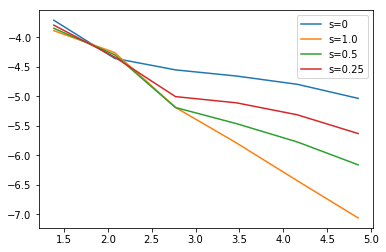

In [46]:
traj=0

# 
#len(spaceDiscr[:-1])
plots = []
for s in noiseSmoothParam:

    someVals = np.zeros(len(spaceDiscr[:-1]))
    for i in range(len(spaceDiscr[:-1])):
        someVals[i] = errorVals[(spaceDiscr[i],s,traj)]

#someVals.shape
    plots.append(plt.plot( np.log(spaceDiscr[:-1]),np.log(someVals), label='s='+str(s)))
    
    

plt.legend()
plt.show()


In [ ]:
###### Fenics #####

# 1) Let us define the domain, the mesh and the function space.
# The domain is (0,1) and we choose an equidistant mesh.
mesh = UnitIntervalMesh(spaceDiscr)

# Lagrange finite element.
V = FunctionSpace(mesh, 'CG', 1)


# 2) Boundary condition
def boundary(x, on_boundary):
    return on_boundary

u_D = 12

bc = DirichletBC(V, u_D, boundary)

# ...
u = TrialFunction(V)
v = TestFunction(V)

# The stiffness matrix
A = assemble(inner(grad(u), grad(v))*dx())

mplot(project(u_D,V))


In [15]:
# Results:
# We expect the results to a list of dictionaries.
# In each dictionary we find again the parameter and the calculated solution.
N = 100
import numpy as np
A = generateStiffness(N)
M = generateMassMatrix(N)

Minv = np.linalg.inv(M)

alpha = np.dot(Minv,A)

np.linalg.cholesky(alpha)

array([[  1.92858989e+02,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -1.36713143e+02,   1.59902941e+02,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.66321762e+01,  -1.45408695e+02,   1.49268424e+02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [ -1.69310910e-53,   6.72067043e-53,  -2.58507684e-52, ...,
          1.28633934e+02,   0.00000000e+00,   0.00000000e+00],
       [  4.51495760e-54,  -1.79217878e-53,   6.89353824e-53, ...,
         -1.61186475e+02,   1.27560184e+02,   0.00000000e+00],
       [ -1.12873940e-54,   4.48044696e-54,  -1.72338456e-53, ...,
          4.02966187e+01,  -1.51845188e+02,   1.11303139e+02]])